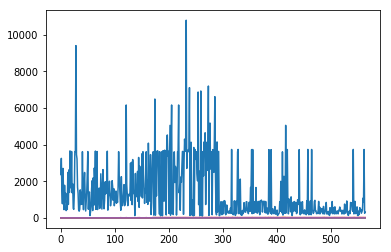

In [55]:
import pandas
import matplotlib.pyplot as plt

# 1st column of csv file is "date" which we don't need. And 3 footer lines can also be skipped.
dataframe = pandas.read_csv('posca_factor_ping-final.csv', usecols=[2,3,4,5,6], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')
plt.plot(dataset)
plt.show()

In [56]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [57]:
# fix random seed for reproducibility
seed = numpy.random.seed(7)

LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. We can easily normalize the dataset using the MinMaxScaler preprocessing class from the scikit-learn library.

In [58]:
# normalize the dataset
data_range = (-1, 1)
scaler = MinMaxScaler(feature_range=data_range)        # scaler can also de-normalize the dataset by scaler.inverse_transform(), useful for actual prediction
dataset_scaled = scaler.fit_transform(dataset)
#dataset_scaled = numpy.array(dataset_scaled)

In [59]:
print(dataset_scaled.shape)
print(len(dataset_scaled))
print(dataset_scaled[0:10])

(564, 5)
564
[[-0.57639802 -0.60000002  0.60000002 -1.         -1.        ]
 [-0.41107166 -0.5         1.         -1.          1.        ]
 [-0.73760992 -0.89999998 -0.60000002 -1.         -1.        ]
 [-0.87507015 -0.69999999  0.20000005 -1.         -1.        ]
 [-0.51374608 -0.5         1.         -1.          1.        ]
 [-0.70675147 -0.69999999  0.20000005 -1.         -1.        ]
 [-0.93510383 -0.80000001 -0.19999999 -1.         -1.        ]
 [-0.68617922 -0.60000002  0.60000002 -1.         -1.        ]
 [-0.85262769 -0.5         1.         -1.          1.        ]
 [-0.76715922 -0.5         1.         -1.          1.        ]]


After we model our data and estimate the skill of our model on the training dataset, we need to get an idea of the skill of the model on new unseen data. For a normal classification or regression problem, we would do this using cross validation.

With time series data, the sequence of values is important. A simple method that we can use is to split the ordered dataset into train and test datasets. The code below calculates the index of the split point and separates the data into the training datasets with 67% of the observations that we can use to train our model, leaving the remaining 33% for testing the model.

In [60]:
# split into train and test sets
train_size = int(len(dataset_scaled) * 0.67)
test_size = len(dataset_scaled) - train_size
train, test = dataset_scaled[0:train_size,:], dataset_scaled[train_size:len(dataset),:]
print(len(train), len(test))

377 187


Now we can define a function to create a new dataset, as described above.

The function takes two arguments: the dataset, which is a NumPy array that we want to convert into a dataset, and the look_back, which is the number of previous time steps to use as input variables to predict the next time period in this case defaulted to 1.

This default will create a dataset where X is the number of passengers at a given time (t) and Y is the number of passengers at the next time (t + 1).

It can be configured, and we will by constructing a differently shaped dataset in the next section.

In [61]:
# convert an array of values into a dataset matrix
def create_dataset(data, look_back=1):
    dataX, dataY = [], []
    i_range = len(data) - look_back - 1
    print(i_range)
    for i in range(0, i_range):
        dataX.append(data[i:(i+look_back)])    # index can move down to len(dataset)-1
        dataY.append(data[i + look_back])      # Y is the item that skips look_back number of items
    
    return numpy.array(dataX), numpy.array(dataY)
# try it
look_back = 4
dataX, dataY = create_dataset(dataset_scaled, look_back=look_back)

559


In [62]:
print("X shape:", dataX.shape)
print("Y shape:", dataY.shape)
   
print("Xt-3     Xt-2      Xt-1      Xt        Y")
print("---------------------------------------------")
for i in range(len(dataX)): 
    print('%.2f   %.2f    %.2f    %.2f    %.2f' % (dataX[i][0][0], dataX[i][1][0], dataX[i][2][0], dataX[i][3][0],dataY[i][0]))

X shape: (559, 4, 5)
Y shape: (559, 5)
Xt-3     Xt-2      Xt-1      Xt        Y
---------------------------------------------
-0.58   -0.41    -0.74    -0.88    -0.51
-0.41   -0.74    -0.88    -0.51    -0.71
-0.74   -0.88    -0.51    -0.71    -0.94
-0.88   -0.51    -0.71    -0.94    -0.69
-0.51   -0.71    -0.94    -0.69    -0.85
-0.71   -0.94    -0.69    -0.85    -0.77
-0.94   -0.69    -0.85    -0.77    -0.94
-0.69   -0.85    -0.77    -0.94    -0.86
-0.85   -0.77    -0.94    -0.86    -0.93
-0.77   -0.94    -0.86    -0.93    -0.55
-0.94   -0.86    -0.93    -0.55    -0.88
-0.86   -0.93    -0.55    -0.88    -0.53
-0.93   -0.55    -0.88    -0.53    -0.76
-0.55   -0.88    -0.53    -0.76    -0.33
-0.88   -0.53    -0.76    -0.33    -0.71
-0.53   -0.76    -0.33    -0.71    -0.65
-0.76   -0.33    -0.71    -0.65    -0.34
-0.33   -0.71    -0.65    -0.34    -0.76
-0.71   -0.65    -0.34    -0.76    -0.67
-0.65   -0.34    -0.76    -0.67    -0.92
-0.34   -0.76    -0.67    -0.92    -0.93
-0.76   -0.67

In [63]:
print("X shape:", dataX.shape)

# Reshape to (samples, timestep, features)
dataX = numpy.reshape(dataX, (dataX.shape[0], 4,dataX.shape[2]))

print("X shape:", dataX.shape)

X shape: (559, 4, 5)
X shape: (559, 4, 5)


In [64]:
#Let's use this function to prepare the train and test datasets for modeling.
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)      # trainX is input, trainY is expected output
testX, testY = create_dataset(test, look_back)

print(trainX.shape)
print(trainY.shape)

375
185
(375, 1, 5)
(375, 5)


The LSTM network expects the input data (X) to be provided with a specific array structure in the form of 3D: [samples, time steps, features], or in other words, 3D tensor with shape (batch_size, timesteps, input_dim), or optionally, 2D tensors with shape (batch_size, output_dim).

Currently, our data is in the form: [samples, features] and we are framing the problem as one time step for each sample. We can transform the prepared train and test input data into the expected structure using numpy.reshape() as follows:

In [65]:
# reshape input to be [samples, time steps, features]

trainX = numpy.reshape(trainX, (trainX.shape[0], look_back, trainX.shape[2]))     # timestep = 1, input_dim = trainX.shape[1]
print("New trainX shape:", trainX.shape)
print(testX.shape)
testX = numpy.reshape(testX, (testX.shape[0],look_back, testX.shape[1]))

print("New trainX shape:", trainX.shape)
print("trainY shape:", trainY.shape)
print("trainY example:", trainY[0])

print(len(testX))

New trainX shape: (375, 1, 5)
(185, 1, 5)


ValueError: cannot reshape array of size 925 into shape (185,1,1)

In [66]:
# create and fit the LSTM network
from keras.layers import Dropout

batch_size = 1
timesteps = trainX.shape[1]
input_dim = trainX.shape[2]
print(timesteps)
print(input_dim)

model = Sequential()
#model.add(LSTM(8, input_shape=(1, look_back)))    
model.add(LSTM(4, batch_input_shape=(batch_size, timesteps, input_dim)))
model.add(Dense(10))    
#model.add(Dropout(0.8))
model.add(Dense(5))
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(trainX, trainY,epochs=1000, batch_size=1, verbose=2)   

1
5
Epoch 1/1000
 - 3s - loss: 0.5430
Epoch 2/1000
 - 1s - loss: 0.2911
Epoch 3/1000
 - 1s - loss: 0.2773
Epoch 4/1000
 - 1s - loss: 0.2735
Epoch 5/1000
 - 1s - loss: 0.2699
Epoch 6/1000
 - 1s - loss: 0.2685
Epoch 7/1000
 - 1s - loss: 0.2672
Epoch 8/1000
 - 1s - loss: 0.2671
Epoch 9/1000
 - 1s - loss: 0.2669
Epoch 10/1000
 - 1s - loss: 0.2668
Epoch 11/1000
 - 1s - loss: 0.2660
Epoch 12/1000
 - 1s - loss: 0.2646
Epoch 13/1000
 - 1s - loss: 0.2650
Epoch 14/1000
 - 1s - loss: 0.2658
Epoch 15/1000
 - 1s - loss: 0.2654
Epoch 16/1000
 - 1s - loss: 0.2649
Epoch 17/1000
 - 1s - loss: 0.2654
Epoch 18/1000
 - 1s - loss: 0.2644
Epoch 19/1000
 - 1s - loss: 0.2647
Epoch 20/1000
 - 1s - loss: 0.2631
Epoch 21/1000
 - 1s - loss: 0.2662
Epoch 22/1000
 - 1s - loss: 0.2653
Epoch 23/1000
 - 1s - loss: 0.2647
Epoch 24/1000
 - 1s - loss: 0.2645
Epoch 25/1000
 - 1s - loss: 0.2643
Epoch 26/1000
 - 1s - loss: 0.2649
Epoch 27/1000
 - 1s - loss: 0.2642
Epoch 28/1000
 - 1s - loss: 0.2647
Epoch 29/1000
 - 1s - los

Epoch 232/1000
 - 1s - loss: 0.2619
Epoch 233/1000
 - 1s - loss: 0.2620
Epoch 234/1000
 - 1s - loss: 0.2618
Epoch 235/1000
 - 1s - loss: 0.2620
Epoch 236/1000
 - 1s - loss: 0.2614
Epoch 237/1000
 - 1s - loss: 0.2622
Epoch 238/1000
 - 1s - loss: 0.2627
Epoch 239/1000
 - 1s - loss: 0.2621
Epoch 240/1000
 - 2s - loss: 0.2621
Epoch 241/1000
 - 1s - loss: 0.2623
Epoch 242/1000
 - 1s - loss: 0.2618
Epoch 243/1000
 - 2s - loss: 0.2621
Epoch 244/1000
 - 1s - loss: 0.2620
Epoch 245/1000
 - 1s - loss: 0.2619
Epoch 246/1000
 - 1s - loss: 0.2617
Epoch 247/1000
 - 2s - loss: 0.2623
Epoch 248/1000
 - 2s - loss: 0.2617
Epoch 249/1000
 - 1s - loss: 0.2608
Epoch 250/1000
 - 1s - loss: 0.2614
Epoch 251/1000
 - 1s - loss: 0.2616
Epoch 252/1000
 - 1s - loss: 0.2618
Epoch 253/1000
 - 1s - loss: 0.2618
Epoch 254/1000
 - 1s - loss: 0.2613
Epoch 255/1000
 - 1s - loss: 0.2625
Epoch 256/1000
 - 1s - loss: 0.2607
Epoch 257/1000
 - 1s - loss: 0.2621
Epoch 258/1000
 - 1s - loss: 0.2612
Epoch 259/1000
 - 1s - loss:

Epoch 460/1000
 - 1s - loss: 0.2606
Epoch 461/1000
 - 1s - loss: 0.2615
Epoch 462/1000
 - 1s - loss: 0.2611
Epoch 463/1000
 - 1s - loss: 0.2607
Epoch 464/1000
 - 1s - loss: 0.2605
Epoch 465/1000
 - 2s - loss: 0.2607
Epoch 466/1000
 - 2s - loss: 0.2613
Epoch 467/1000
 - 2s - loss: 0.2599
Epoch 468/1000
 - 2s - loss: 0.2611
Epoch 469/1000
 - 2s - loss: 0.2610
Epoch 470/1000
 - 2s - loss: 0.2601
Epoch 471/1000
 - 2s - loss: 0.2609
Epoch 472/1000
 - 2s - loss: 0.2600
Epoch 473/1000
 - 2s - loss: 0.2605
Epoch 474/1000
 - 2s - loss: 0.2608
Epoch 475/1000
 - 2s - loss: 0.2608
Epoch 476/1000
 - 1s - loss: 0.2607
Epoch 477/1000
 - 1s - loss: 0.2608
Epoch 478/1000
 - 1s - loss: 0.2608
Epoch 479/1000
 - 1s - loss: 0.2608
Epoch 480/1000
 - 1s - loss: 0.2605
Epoch 481/1000
 - 1s - loss: 0.2606
Epoch 482/1000
 - 1s - loss: 0.2608
Epoch 483/1000
 - 1s - loss: 0.2607
Epoch 484/1000
 - 1s - loss: 0.2607
Epoch 485/1000
 - 1s - loss: 0.2609
Epoch 486/1000
 - 1s - loss: 0.2606
Epoch 487/1000
 - 1s - loss:

Epoch 688/1000
 - 1s - loss: 0.2601
Epoch 689/1000
 - 1s - loss: 0.2603
Epoch 690/1000
 - 1s - loss: 0.2604
Epoch 691/1000
 - 1s - loss: 0.2599
Epoch 692/1000
 - 1s - loss: 0.2604
Epoch 693/1000
 - 1s - loss: 0.2603
Epoch 694/1000
 - 1s - loss: 0.2600
Epoch 695/1000
 - 1s - loss: 0.2602
Epoch 696/1000
 - 1s - loss: 0.2602
Epoch 697/1000
 - 1s - loss: 0.2603
Epoch 698/1000
 - 1s - loss: 0.2608
Epoch 699/1000
 - 1s - loss: 0.2602
Epoch 700/1000
 - 1s - loss: 0.2598
Epoch 701/1000
 - 1s - loss: 0.2601
Epoch 702/1000
 - 1s - loss: 0.2602
Epoch 703/1000
 - 1s - loss: 0.2605
Epoch 704/1000
 - 2s - loss: 0.2606
Epoch 705/1000
 - 1s - loss: 0.2604
Epoch 706/1000
 - 1s - loss: 0.2605
Epoch 707/1000
 - 1s - loss: 0.2602
Epoch 708/1000
 - 1s - loss: 0.2603
Epoch 709/1000
 - 1s - loss: 0.2597
Epoch 710/1000
 - 1s - loss: 0.2599
Epoch 711/1000
 - 1s - loss: 0.2599
Epoch 712/1000
 - 1s - loss: 0.2604
Epoch 713/1000
 - 1s - loss: 0.2602
Epoch 714/1000
 - 1s - loss: 0.2604
Epoch 715/1000
 - 1s - loss:

Epoch 916/1000
 - 1s - loss: 0.2599
Epoch 917/1000
 - 1s - loss: 0.2605
Epoch 918/1000
 - 1s - loss: 0.2597
Epoch 919/1000
 - 1s - loss: 0.2596
Epoch 920/1000
 - 1s - loss: 0.2604
Epoch 921/1000
 - 1s - loss: 0.2599
Epoch 922/1000
 - 1s - loss: 0.2599
Epoch 923/1000
 - 1s - loss: 0.2598
Epoch 924/1000
 - 1s - loss: 0.2603
Epoch 925/1000
 - 1s - loss: 0.2600
Epoch 926/1000
 - 1s - loss: 0.2596
Epoch 927/1000
 - 1s - loss: 0.2602
Epoch 928/1000
 - 1s - loss: 0.2596
Epoch 929/1000
 - 1s - loss: 0.2598
Epoch 930/1000
 - 1s - loss: 0.2598
Epoch 931/1000
 - 1s - loss: 0.2601
Epoch 932/1000
 - 1s - loss: 0.2597
Epoch 933/1000
 - 1s - loss: 0.2601
Epoch 934/1000
 - 1s - loss: 0.2601
Epoch 935/1000
 - 1s - loss: 0.2602
Epoch 936/1000
 - 1s - loss: 0.2597
Epoch 937/1000
 - 1s - loss: 0.2600
Epoch 938/1000
 - 1s - loss: 0.2602
Epoch 939/1000
 - 1s - loss: 0.2594
Epoch 940/1000
 - 1s - loss: 0.2599
Epoch 941/1000
 - 1s - loss: 0.2603
Epoch 942/1000
 - 1s - loss: 0.2600
Epoch 943/1000
 - 1s - loss:

Once the model is fit, we can estimate the performance of the model on the train and test datasets. This will give us a point of comparison for new models.

Note that we invert the predictions before calculating error scores to ensure that performance is reported in the same units as the original data (thousands of passengers per month

In [67]:
# make predictions
#print(trainX.shape)
#print(testX.shape)
#print(len(trainX))
#print(len(testX))

trainPredict = model.predict(trainX, batch_size)

#print(trainPredict)
testPredict = model.predict(testX,batch_size)      
#print(testPredict)


# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)               # trainY is of shape (samples, features) while trainX is of (samples, timesteps, features) )
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

print("trainY shape:", trainY.shape)
print("trainPredict shape:", trainPredict.shape)
print("testY shape:", testY.shape)
print("testPredict shape:", testPredict.shape)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

trainY shape: (375, 5)
trainPredict shape: (375, 5)
testY shape: (185, 5)
testPredict shape: (185, 5)
Train Score: 680.99 RMSE
Test Score: 603.98 RMSE


Finally, we can generate predictions using the model for both the train and test dataset to get a visual indication of the skill of the model.

Because of how the dataset was prepared, we must shift the predictions so that they align on the x-axis with the original dataset (because the output Y is 1 timestep shift from input X). Once prepared, the data is plotted, showing the original dataset in blue, the predictions for the training dataset in green, and the predictions on the unseen test dataset in red.

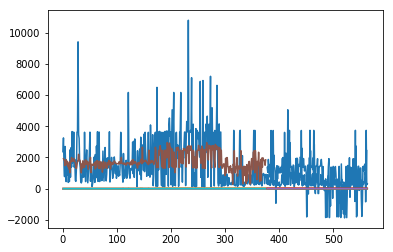

In [68]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
#print(trainPredictPlot[0])
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset_scaled))
#plt.plot(dataset_scaled)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()